In [1]:
from torchvision import datasets
from models import Vgg16, AlexNet
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from methods import data_handler
import tensorflow as tf

from copy import deepcopy
import itertools
from PIL import Image

import captum

## Load test data

In [2]:
img_folder = datasets.ImageFolder(root=r'C:\Users\julia\Dokumente\GitHub\development\data2\imagenetv2-matched-frequency-format-val')

In [16]:
def sample_random_images(img_folder, number, seed=None):
    images = []
    img_paths = img_folder.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = img_folder.loader(rand_img_path)
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
    return np.array(images)

In [20]:
def sample_random_images_PIL(img_folder, number, seed=None):
    images = []
    img_paths = img_folder.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = img_folder.loader(rand_img_path)
        images.append(rand_img)
    return images

In [4]:
def load_entire_val_set(img_folder):
    """
    So liegen alle Bilder als np array vor; müssen aber als torch-tensor-vorliegen vorliegen
    """
    images = []
    labels_idx = []
    for img_path in tqdm(img_folder.imgs):
        rand_img = img_folder.loader(img_path[0])
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
        labels_idx.append(int(img_path[0].split("\\")[-2]))
    return np.array(images), np.array(labels_idx)

In [29]:
# get all images
images, labels_idx = load_entire_val_set(img_folder)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 140.96it/s]


In [5]:
labels = data_handler.get_labels()

Using downloaded and verified file: .\data/imagenet_class_index.json


In [21]:
# sample images
imgs = sample_random_images_PIL(img_folder, 5, seed=3)

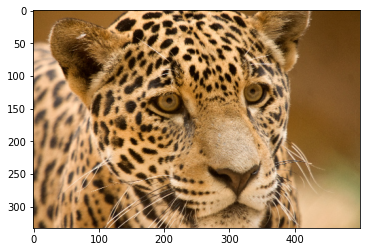

In [22]:
plt.imshow(imgs[3])

## Preprocess test data (for PyTorch)

In [34]:
IMG_IDX = 3

In [35]:
input_tensor = data_handler.transform()(imgs[IMG_IDX])
input_tensor = input_tensor.unsqueeze(0)

## Load model

In [25]:
model = Vgg16()
#model = AlexNet()

Using downloaded and verified file: .\data/imagenet_class_index.json


In [26]:
output = model.predict(input_tensor)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [38]:
out_idx = probabilities.detach().numpy().argmax()
out_idx

288

In [54]:
probabilities[out_idx]

tensor(0.7628, grad_fn=<SelectBackward0>)

In [39]:
labels[str(out_idx)]

['n02128385', 'leopard']

## XAI: Integrated Gradients

In [44]:
# https://captum.ai/docs/extension/integrated_gradients
# https://captum.ai/api/integrated_gradients.html#
# https://captum.ai/tutorials/CIFAR_TorchVision_Interpret

In [78]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [90]:
ind = out_idx
input_tensor.requires_grad = True

In [106]:
def attribute_image_features(algorithm, input, **kwargs):
    model.model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=int(out_idx),
                                              **kwargs
                                             )
    
    return tensor_attributions

In [110]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input_tensor, baselines=input_tensor * 0, return_convergence_delta=True)
print(attr_ig.shape)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

torch.Size([1, 3, 224, 224])
Approximation delta:  tensor([0.3196], dtype=torch.float64)


In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input_tensor, baselines=input_tensor * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [114]:
outputs = model(input_tensor)

_, predicted = torch.max(outputs, 1)

In [118]:
predicted

tensor([288])

In [122]:
input_tensor.cpu().detach().numpy().shape

(1, 3, 224, 224)

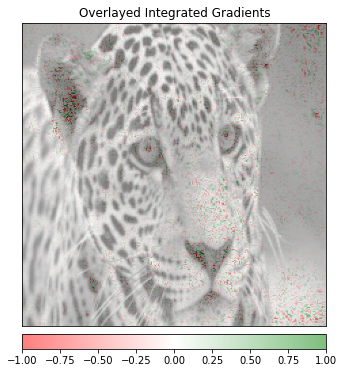

In [124]:
# print('Original Image')
# print('Predicted:', labels[predicted[ind]], 
#       ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose(input_tensor.cpu().detach().numpy()[0] , (1, 2, 0))# / 2) + 0.5
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

In [126]:
_[0].savefig("test.png")

In [ ]:
# was soll target sein?
# was ist genau der output?
# spuckt diese Implementierung irgendwie ein Orginalbild + Overlay aus?

## XAI: Anchor

In [ ]:
"""
Derzeitiges Problem:

Siehe Fehlermeldung unten. In BSP wurde auch TF benutzt. Vielleicht doch nicht so toll mit PyTorch kompatibel...
"""

In [59]:
from alibi.explainers import AnchorImage

In [60]:
predict_fn = lambda x: model.predict(x)

In [70]:
im = (224, 224, 3)

In [71]:
im[:2]

(224, 224)

In [75]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [77]:
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, (3, 224, 224), segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

AlibiPredictorCallException: Predictor failed to be called on <class 'numpy.ndarray'> of shape (1, 3, 224) and dtype float32. Check that the parameter `image_shape` is correctly specified.

In [ ]:
image = images[i]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)

In [ ]:
# Superpixels in the anchor
plt.imshow(explanation.anchor)

In [ ]:
# A visualization of all the superpixels
plt.imshow(explanation.segments);

## XAI: